In [1]:
from functools import partial, reduce
from typing import TypedDict, Optional
from collections import ChainMap

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
from IPython.display import HTML

c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [21]:
def ak_gain(k, a0=1e-2, A=1000, alpha=0.602):
    """Rule of thumb, A ~ <=10% max iterations expected
    a0 to be smallest of desired changes among theta early on"""
    a = a0 * (1 + A) ** alpha
    return a / (k + 1 + A) ** alpha


def ck_gain(k, c=1e-2, gamma=0.101):
    """Rule of thumb, c ~ std loss noise (e in y = L + e)"""
    return c / (k + 1) ** gamma


def approx_gradient(loss, theta, c):
    # SPSA
    P = len(theta)
    perturbs = np.eye(P) * c
    left_thetas = theta + perturbs
    right_thetas = theta - perturbs
    left_loss = np.apply_along_axis(loss, arr=left_thetas, axis=1)
    right_loss = np.apply_along_axis(loss, arr=right_thetas, axis=1)
    diff = (left_loss - right_loss) / (2 * c)
    return diff


def optim_fdsa(theta_0, loss_fnc, ak_gen, ck_gen, max_theta_diff=0.1, num_approx=1):
    theta = theta_0
    P = len(theta)
    k = 0
    while True:
        ak = ak_gen(k)
        ck = ck_gen(k)
        grad = approx_gradient(loss_fnc, theta, ck)
        assert grad.shape == theta.shape, grad.shape
        theta_diff = ak * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > max_theta_diff:
            theta_diff *= max_theta_diff / theta_diff_mag
        theta = theta - theta_diff
        yield theta


In [22]:
goal_theta = np.array([1, 1, 2])
c = 1e-2
perturbs = np.eye(len(goal_theta)) * c
np.apply_along_axis(np.sum, arr=goal_theta + perturbs, axis=1)

array([4.01, 4.01, 4.01])

In [23]:
# simple thing is 'root' finding, where loss is just the current value, and theta is x
goal_theta = np.array([1, 1])

def simple_loss(theta):
    diff = np.asarray(theta) - goal_theta
    return np.sqrt(diff@diff)

theta_0 = np.array([0.5, 1.5])

optim = optim_fdsa(theta_0, simple_loss, ak_gain, ck_gain)

In [24]:
for i, theta in zip(range(100), optim):
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.6971072811990432
10: 0.5971131947186946
20: 0.4971214633947892
30: 0.397133843814653
40: 0.2971544169096828
50: 0.19719533012923499
60: 0.09731612543862446
70: 0.001732312038338994
80: 0.0
90: 0.0


In [7]:
theta

array([0.99999987, 1.00000013])

In [25]:
thetas = []
optim = optim_fdsa(theta_0, simple_loss, partial(ak_gain, a0=1, A=1), partial(ck_gain, c=1e-2))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.6071067811865475
10: 0.007106781186547335
20: 0.007106781186547335
30: 0.007106781186547335
40: 0.007106781186547335
50: 0.007106781186547335
60: 0.007106781186547335
70: 0.007106781186547335
80: 0.007106781186547335
90: 0.007106781186547335


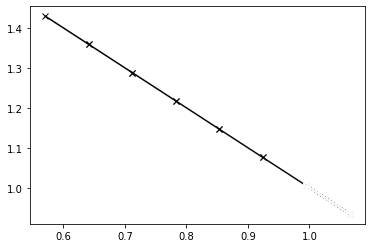

In [26]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")

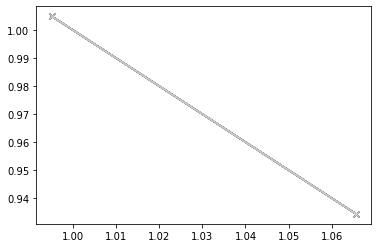

In [27]:
num_segments = 10
for i in range(10 - 1):
    x1, y1 = thetas[-10 + i]
    x2, y2 = thetas[-10 + i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")

In [28]:
# simple thing is 'root' finding, where loss is just the current value, and theta is x
goal_theta = np.array([1, 1])

def noise_source(noise_scale=1e-3):
    return np.random.normal(0, noise_scale, size=len(goal_theta))

def noisy_loss(theta, noise_scale=1e-3, v=None):
    if v is None:
        v = noise_source(noise_scale)
    diff = np.asarray(theta) - goal_theta + v
    return np.sqrt(diff@diff)

theta_0 = np.array([0.5, 1.5])

In [29]:
thetas = []
optim = optim_fdsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.1, A=10), partial(ck_gain, c=1e-2))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.638273846307222
10: 0.7666804901689027
20: 0.6254175571155449
30: 0.6499555263795918
40: 0.7471108108635548
50: 0.8259033240492102
60: 0.8209439885894466
70: 0.6381046081140225
80: 0.5200607045914333
90: 0.7308345909857605


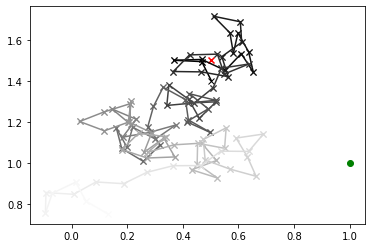

In [30]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

In [31]:
thetas = []
optim = optim_fdsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.1, A=10), partial(ck_gain, c=0.5))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.6445156404411311
10: 0.1278417617756606
20: 0.019121312215068745
30: 0.03679687171309899
40: 0.03461159353572204
50: 0.04206001693488121
60: 0.029697765685052294
70: 0.012870598826862386
80: 0.020502911021815833
90: 0.023223182198721777


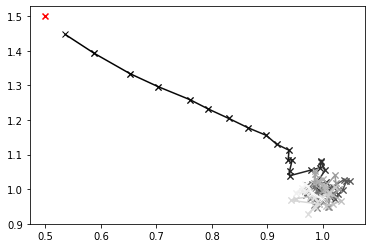

In [32]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

In [33]:
thetas = []
optim = optim_fdsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.001, A=20), partial(ck_gain, c=0.01))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.7135834396493198
10: 0.6925345575301592
20: 0.6706893650761454
30: 0.6599240004256537
40: 0.6559157602585971
50: 0.6668789465316818
60: 0.6686217945411483
70: 0.6105410608747147
80: 0.5750120368226563
90: 0.5851857397336357


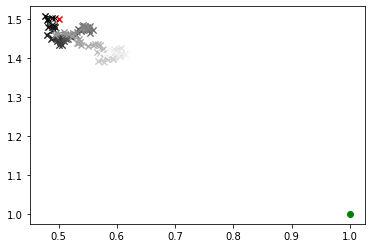

In [34]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

In [41]:

# def approx_gradient(loss, perturb, theta, c):
#     # SPSA
#     diff = loss(theta + c * perturb) - loss(theta - c * perturb)
#     return (diff / (2 * c)) / perturb

class FDSA_Params(TypedDict):
    a0: float
    c0: float
    A: int
    gamma: float  # 0.101
    alpha: float # 0.602
    max_delta_theta: float  # normalize
    max_iter: int
    t0: float
    num_approx: int


# a = a0 * (1 + A) ** alpha
# return a / (k + 1 + A) ** alpha

class OptimFDSA:
    _default_params: FDSA_Params = {"gamma": 0.101, "alpha": 0.602, "t0": .5, "num_approx": 1} 
    _required_params = {"max_iter", "max_delta_theta"}
    _params: FDSA_Params
    def __init__(self, theta_0, loss_fnc, v_fnc=None, blocking=False, **params):
        self._params = dict(ChainMap(params, self._default_params))
        assert len(self._required_params - set(self._params)) == 0, self._required_params
        self.theta_0 = np.asarray(theta_0)
        self.blocking = blocking
        self.loss = loss_fnc
        self.v_fnc = v_fnc
        self._all_loss_history = []
        self._loss_history = []
        self._used_thetas = []
        self._block_history = []
        self._grad_history = []
        self.thetas = [self.theta_0]
        self.k = 0
        self._c_guess = self._params.get("c0")
    
    def calibrate(self, debug=False):
        self._params["A"] = self._params["max_iter"] * 0.13
        self._params["c0"] = self._approximate_c(c_guess = self._c_guess)
        # approximate grad, and take magnitude...
        self._params["a0"] = self._approximate_a(self._params["max_delta_theta"])
        if debug:
            print("After calibration: ", self._params)
    
    def _get_loss(self, theta, v=None):
        loss = self.loss(theta, v=v)
        self._all_loss_history.append(loss)
        self._used_thetas.append(theta)
        return loss
    
    def _approximate_a(self, max_delta_theta, num_approx=10):
        approx_grad = np.mean([self.approx_grad() for i in range(num_approx)], axis=0)
        # |a / (k + 1 + A) ** alpha * grad| = max_delta_theta
        max_grad = np.abs(approx_grad).max()
        a0 = (1 + self._params["A"])**self._params["alpha"] * max_delta_theta / max_grad
        return a0

        
    def _approximate_c(self, num_samples=10, c_guess=None):
        losses = [self._get_loss(self.theta_0) for i in range(num_samples)]
        c_est = np.std(losses, ddof=1) * 2  + 1e-10 # over-estimate it...
        if c_guess is None:
            return c_est
        # geometric mean of the guess and estimate
        return np.sqrt(c_est * c_guess)
    
    def _get_perturb(self):
        return next(self._perturb_gen)

    def approx_grad(self):
        c = self.ck(self.k)
        # SPSA
        P = len(self.theta)
        perturbs = np.eye(P) * c
        left_thetas = self.theta + perturbs
        right_thetas = self.theta - perturbs
        v = None
        if self.v_fnc is not None:
            v = self.v_fnc()
        left_loss = np.apply_along_axis(self._get_loss, arr=left_thetas, axis=1, v=v)
        right_loss = np.apply_along_axis(self._get_loss, arr=right_thetas, axis=1, v=v)
        grad = (left_loss - right_loss) / (2 * c)
        self._grad_history.append(grad)
        return grad
    
    def ck(self, k):
        return self._params["c0"] / (k + 1) ** self._params["gamma"]

    def ak(self, k):
        return self._params["a0"] / (k + 1 + self._params["A"]) ** self._params["alpha"]
    
    @property
    def theta(self):
        return self.thetas[-1]

    def step(self):
        a = self.ak(self.k)
        
        for i in range(self._params["num_approx"]):
            self.approx_grad()
        grad = np.mean(self._grad_history[-self._params["num_approx"]:], axis=0)
        theta_diff = a * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > self._params["max_delta_theta"]:
            theta_diff *= self._params["max_delta_theta"] / theta_diff_mag
        
        # we let it be a max... 
        loss = self.loss(self.theta - theta_diff)  # don't count it...
        block = False
        if self.blocking and self.k > 5:
            std_loss = np.std(self._loss_history[-10:])
            block = loss >= self._loss_history[-1] + std_loss * self.temp(self.k)
        self._block_history.append(block)
        if not block:
            self.thetas.append(self.theta - theta_diff)
            self._loss_history.append(loss)


        self.k += 1
        return self.theta
    
    def temp(self, k):
        return self._params["t0"] / (k + 1)**self._params["gamma"]
    
    def _print_progress(self):
        print(f"{self.k}: {self._loss_history[-1]}")

    def irun(self, num_steps=None, print_progress=True):
        if num_steps is None:
            num_steps = self._params["max_iter"]
        pi = int(num_steps // 10)
        for i in range(num_steps):
            theta = self.step()
            if print_progress and i % pi == 0:
                self._print_progress()
            yield theta
    
    def run(self, num_steps=None, print_progress=True):
        for theta in self.irun(num_steps=num_steps, print_progress=print_progress):
            pass
        return theta




optim = OptimFDSA(theta_0, partial(noisy_loss, noise_scale=1e-4), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
theta = optim.run()

1: 0.5571037282335697
11: 0.03613775994183596
21: 0.011412053786423427
31: 0.012522417580397118
41: 0.012507027677625664
51: 0.012017209270355232
61: 0.008435527112641606
71: 0.010114250447364264
81: 0.009248959913196318
91: 0.004247888525336516


In [37]:
np.mean(optim.thetas[-10:], axis=0)

array([0.99290683, 1.00165484])

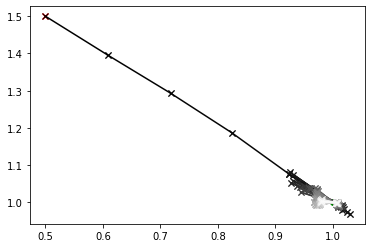

In [38]:
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

1: 0.55729087251964
11: 0.030215635520940615
21: 0.013952996338387662
31: 0.010781231781031582
41: 0.011190271140216595
51: 0.005124285358760686
61: 0.007159420884389839
71: 0.0033178670799364498
81: 0.01175116210321887
91: 0.010954012519384633


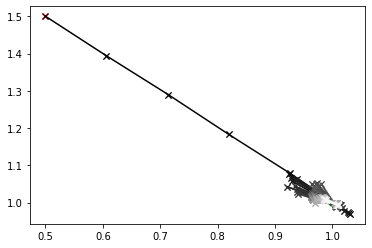

In [39]:
optim = OptimFDSA(theta_0, partial(noisy_loss, noise_scale=1e-4), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

1: 0.5241656321388524
11: 0.1974184413642619
21: 0.16452323577360892
31: 0.0337908994306354
41: 0.19547549476754325
51: 0.1555147644463918
61: 0.07683667534282014
71: 0.09837535222551604
81: 0.16368934495641033
91: 0.06035904506008392


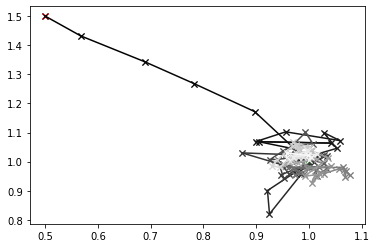

In [40]:
optim = OptimFDSA(theta_0, partial(noisy_loss, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

1: 0.5563368110970386
11: 0.1546300675416833
21: 0.09558053679311275
31: 0.07499903630214444
41: 0.03507208122147816
51: 0.036111407463362694
61: 0.029184539846151145
71: 0.009751892349130537
81: 0.02419170021724552
91: 0.03975134972408545


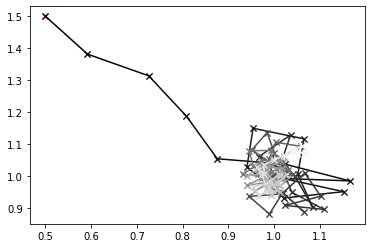

In [42]:
optim = OptimFDSA(theta_0, noisy_loss, v_fnc=partial(noise_source, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

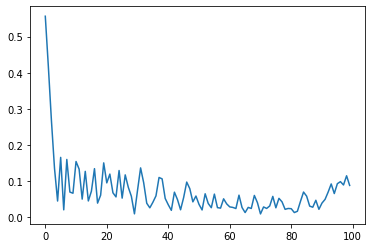

In [43]:
plt.plot(optim._loss_history)

In [44]:
noisy_loss(goal_theta, noise_scale=1e-1)

0.11955066962239641

In [46]:
def experiment():
    optim = OptimFDSA(theta_0, partial(noisy_loss, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1.5, c0=1e-1, num_approx=3)
    optim.calibrate()
    optim.run(print_progress=False)    
    return optim._loss_history

losses = np.array(list(zip(*[experiment() for i in range(100)])))
losses.shape

(100, 100)

In [183]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-3), max_delta_theta=0.15, max_iter=100, alpha=1.5, c0=1e-1, num_approx=1)
optim.calibrate()
theta = optim.run(print_progress=False)    

In [184]:
theta

array([0.99846489, 1.00074841])

C:\Users\bobla\AppData\Local\Temp\ipykernel_8104\31005410.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0.8)` for the same effect.

  sns.lineplot(data=df_melted, x="Time", y="Value",  ci=0.80)


<AxesSubplot:xlabel='Time', ylabel='Value'>

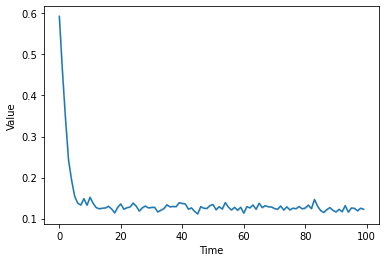

In [47]:

time_points = np.arange(losses.shape[0])
df = pd.DataFrame(losses, columns=[f"Experiment {i+1}" for i in range(losses.shape[1])])
df['Time'] = time_points
df_melted = df.melt(id_vars=['Time'], var_name='Experiment', value_name='Value')
sns.lineplot(data=df_melted, x="Time", y="Value",  ci=0.80)

After calibration:  {'gamma': 0.101, 'alpha': 1, 't0': 0.5, 'max_delta_theta': 0.15, 'max_iter': 100, 'c0': 0.20037526850558537, 'A': 13.0, 'a0': 3.6377578716142067}
1: 0.6272814460418288
11: 0.23254741223008624
21: 0.16432103520417357
31: 0.19349876046648048
41: 0.11389911689205648
51: 0.19843633283719472
61: 0.07898232529334323
71: 0.16850022727883326
81: 0.12476041139831305
91: 0.09510010033657837


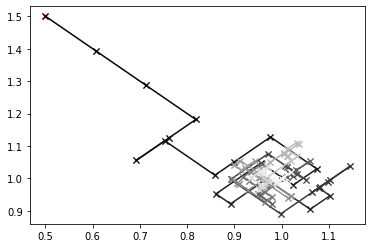

In [132]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

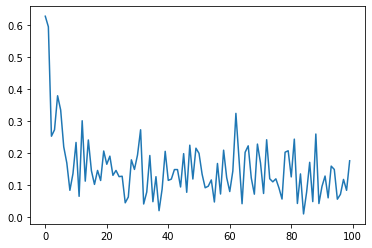

In [133]:
plt.plot(optim._loss_history)

After calibration:  {'gamma': 0.101, 'alpha': 1, 't0': 0.01, 'max_delta_theta': 0.15, 'max_iter': 100, 'c0': 0.16601043379020877, 'A': 13.0, 'a0': 2.8709803545378625}
1: 0.6575557425366739
11: 0.23971402219837634
21: 0.08061346264849711
31: 0.033067257102087834
41: 0.033067257102087834
51: 0.014874364988140725
61: 0.014874364988140725
71: 0.014874364988140725
81: 0.014874364988140725
91: 0.014874364988140725


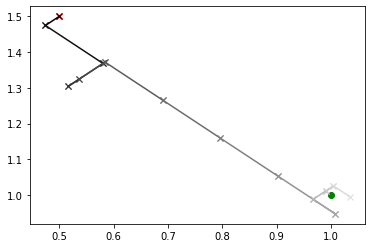

In [125]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-1), blocking=True, max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1, t0=0.01)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

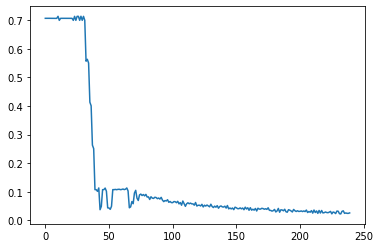

In [103]:
plt.plot(optim._loss_history)

Let's say we have an idea of the max/average distance of t0 to goal, and how noisy we expect it to be

So let's let c be estimated from the measurements, we can do N measurements at the same thing, then approximate...

You might expect that they are relatively interchangeable, but they're not really...

So we expect gradient to decrease as we get closer to 0....


In [72]:
noisy_loss(theta)

0.9991674844653989